# **通过内置方法进行训练和评估**

### **引入**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### **介绍**

本指南涵盖在使用内置API进行训练和验证时的，训练，评估和预测(推断)模型(例如`model.fit()`，`model.evaluate()`，`model.predict()`)。

如果你有兴趣在自定义的训练步骤方法中利用`fit()`，请参阅指南[“自定义fit()的内容”](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit/)。

如果你有兴趣从头开始编写自己的训练和评估循环，请参阅指南[“从头开始编写训练循环”](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch/)。

通常情况下，无论你是使用内置循环还是编写自己的循环，模型训练和评估都在Keras模型中严格按照相同的方式工作--Sequential模型，使用函数式API构建的模型以及从头开始编写的子类化模型。

本指南不涉及分布式训练。想要了解有关分布式训练的内容，请参阅我们的[多GPU和分布式训练](https://www.tensorflow.org/guides/distributed_training)指南。

### **API概述：第一个端到端示例**

将数据传递到模型的内置训练循环时，应该使用**NumPy数组**(如果数据较小并且适合在内存中计算)或`tf.data.Dataset`对象。在接下来的几段中，我们将[MNIST](http://yann.lecun.com/exdb/mnist/)数据集用作NumPy数组，以演示如何使用优化器，损失函数和性能指标。

让我们思考以下模型(在这里，我们构建时使用函数式API，但是它也可以是Sequential模型或子类化模型)：

In [2]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

这是典型的端到端工作流程，包括：
+ 训练
+ 由原始训练数据中生成的验证集进行验证
+ 在测试集上进行评估

我们将会使用MNIST数据集进行示例

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# 预处理数据(这些是NumPy数组)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# 保留10000个样本作为验证集
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]


11493376/11490434 [==============================] - 0s 0us/step


接下来，我们指定训练配置(优化器，损失，指标)：

In [4]:
model.compile(
  optimizer=keras.optimizers.RMSprop(),  # 优化器
  # 最小化损失函数
  loss=keras.losses.SparseCategoricalCrossentropy(),
  # 用于监控的性能指标列表
  metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

我们调用`fit()`，它将数据切成大小为“ `batch_size`”的批量，并依据给定的“`epochs`”，重复遍历整个数据集来训练模型。

In [5]:
print("Fit model on training data")
history = model.fit(
  x_train,
  y_train,
  batch_size=64,
  epochs=2,
  # 在每次epoch结束时，我们都会通过一些验证数据来监控验证损失和指标
  validation_data=(x_val, y_val),
)


Fit model on training data
Epoch 1/2
782/782 [==============================] - 5s 6ms/step - loss: 0.3444 - sparse_categorical_accuracy: 0.9032 - val_loss: 0.2253 - val_sparse_categorical_accuracy: 0.9300
Epoch 2/2
782/782 [==============================] - 4s 6ms/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9516 - val_loss: 0.1489 - val_sparse_categorical_accuracy: 0.9581


返回的“history”对象保留训练期间的损失值和指标的记录：

In [6]:
history.history

{'loss': [0.34440574049949646, 0.16484029591083527],
 'sparse_categorical_accuracy': [0.9031599760055542, 0.9515600204467773],
 'val_loss': [0.22533386945724487, 0.1489294320344925],
 'val_sparse_categorical_accuracy': [0.9300000071525574, 0.9581000208854675]}

我们通过`validate()`在测试数据上评估模型：

In [7]:
# 使用`evaluate'在测试数据上评估模型
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# 生成预测（概率-最后一层的输出）
# 新数据使用`predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
79/79 [==============================] - 0s 4ms/step - loss: 0.1471 - sparse_categorical_accuracy: 0.9569
test loss, test acc: [0.14709877967834473, 0.9569000005722046]
Generate predictions for 3 samples
predictions shape: (3, 10)


现在，让我们来复盘这个工作流程的细节

### **compile()方法：指定损失，指标和优化器**

要使用`fit()`训练模型，你需要指定损失函数，优化器以及可选的一些要监控的指标。

你将它们作为compile()方法的参数传递给模型：

In [8]:
model.compile(
  optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics`参数应为列表-你的模型可以具有任意数量的指标。

如果模型具有多个输出，则可以为每个输出指定不同的损失和指标，并且可以调整每个输出对模型总损失的影响。你可以在后面“**将数据传递到多输入，多输出模型**”小节中，找到有关此内容的更多详细信息。

值得一提的是，如果你经常使用默认设置，那么在许多情况下，可以通过字符串标识符，引用优化器，损失和指标：

In [9]:
model.compile(
  optimizer="rmsprop",
  loss="sparse_categorical_crossentropy",
  metrics=["sparse_categorical_accuracy"],
)

为了方便后面的重用，在这里我们模型定义和编译步骤封装为函数。我们将在本指南的不同示例中多次调用它们。

In [10]:
def get_uncompiled_model():
  inputs = keras.Input(shape=(784,), name="digits")
  x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = layers.Dense(64, activation="relu", name="dense_2")(x)
  outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model


def get_compiled_model():
  model = get_uncompiled_model()
  model.compile(
      optimizer="rmsprop",
      loss="sparse_categorical_crossentropy",
      metrics=["sparse_categorical_accuracy"],
  )
  return model

#### **许多可用的内置优化器，损失和指标**

通常情况下，你不必从头开始创建自己的损失，指标或优化器，因为大部分所需的可能已经封装在Keras API中：

优化器：
+ `SGD()`(有没有动量)
+ `RMSprop()`
+ `Adam()`
+ 等等

损失：

+ `MeanSquareError()`
+ `KLDivergence()`
+ `CosineSimilarity()`
+ 等等

指标：
+ `AUC()`
+ `Precision()`
+ `Recall()`
+ 等等

#### 自定义损失
使用Keras提供两种方式来支持自定义损失。第一个示例创建一个接受输入`y_true`和`y_pred`的函数。第二个示例展示了一个损失函数，该函数计算实际数据和预测之间的均方误差：


In [11]:
def custom_mean_squared_error(y_true, y_pred):
  return tf.math.reduce_mean(tf.square(y_true - y_pred))

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# 我们需要对标签进行ont-hot编码才能使用MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)


782/782 [==============================] - 3s 3ms/step - loss: 0.0158


如果你自定义的损失函数，需要使用除`y_true`和`y_pred`的其他参数，则可以对[`tf.keras.losses.Loss`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss)类进行子类化，并实现以下两种方法：

+ `__init __(self)`：接受在损失函数调用期间传递的参数

+ `call(self，y_true，y_pred)`：使用目标（y_true）和模型预测（y_pred）计算模型的损失

假设你要使用均方误差，需要加上一个附加项，使得预测值远远偏离0.5（我们假设分类目标是one_hot编码的，且取值介于0到1之间）。这激励了模型不要过于自信，这可能有助于减少过度拟合（在尝试之前，我们不知道它是否有效！）。

下面示例如何实现：

In [12]:
class CustomMSE(keras.losses.Loss):
  def __init__(self, regularization_factor=0.1, name="custom_mse"):
    super().__init__(name=name)
    self.regularization_factor = regularization_factor

  def call(self, y_true, y_pred):
    mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
    reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
    return mse + reg * self.regularization_factor

model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.0387


#### **自定义指标**

如果需要的指标不在API中，则可以通过继承`tf.keras.metrics.Metric`类的方式，轻松创建自定义指标。你将需要实现如下4种方法：
+ `__init__(self)`，在其中你将为指标创建状态变量。
+ `update_state(self, y_true, y_pred, sample_weight=None)`，它使用目标`y_true`和模型预测`y_pred`更新状态变量。
+ `result(self)`，它使用状态变量来计算最终结果。
+ `reset_states(self)`，重新初始化指标的状态。

状态更新和结果计算需要分开(分别在`update_state()`和`result()`中)，因为在某些情况下，计算结果的代价可能非常高，所以只能定期执行。

下面是一个简单的示例，展示了如何实现`CategoricalTruePositives`指标，该指标计算多少个样本被正确分类：

In [13]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.3365 - categorical_true_positives: 45174.0000
Epoch 2/3
782/782 [==============================] - 4s 4ms/step - loss: 0.1552 - categorical_true_positives: 47709.0000
Epoch 3/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1140 - categorical_true_positives: 48279.0000


#### **非标准的方式处理损失和指标**

可以利用`y_true`和`y_pred`计算出绝大多数损失和指标，其中`y_pred`是模型的输出，但并不意味着所有损失和指标都能计算。例如，正则化损失可能仅需要层的激活(在这种情况下没有目标)，并且此激活可能不是模型输出。

在这种情况下，你可以在自定义层的调用方法内部调用`self.add_loss(loss_value)`。以这种方式添加的损失会在训练期间添加到“主要”损失中(传递给`compile()`的损失)。下面是一个添加正则化的简单示例(请注意，活动正则化内置在所有Keras层中--下面的层仅是为了提供一个具体示例)：

In [14]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# 将活动正则化插入为一层
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# 由于正则化组件，显示的损失将比之前的损失高得多。
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 2.4884


你可以使用`add_metric()`对记录的指标值执行相同的操作：

In [15]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # `aggregation`参数定义了在每个epoch中如何汇总每个
        # 批处理值：在下面的情况下，我们只需对它们进行平均即可。
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# 将其插入为一层
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.3418 - std_of_activation: 0.9762


在函数式API中，你可以调用`model.add_loss(loss_tensor)`或者`model.add_metric(metric_tensor, name, aggregation)`

下面简单举例：

In [16]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 2.4859 - std_of_activation: 0.0018


注意了，当你通过`add_loss()`传递损失时，可以在没有损失函数的情况下调用`compile()`，因为该模型已经具有最小化的损失。

思考以下`LogisticEndpoint`层：它以targets和logits作为输入，并通过`add_loss()`跟踪交叉熵损失。它还通过`add_metric()`跟踪分类准确性。

In [17]:
class LogisticEndpoint(keras.layers.Layer):
  def __init__(self, name=None):
      super(LogisticEndpoint, self).__init__(name=name)
      self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
      self.accuracy_fn = keras.metrics.BinaryAccuracy()

  def call(self, targets, logits, sample_weights=None):
      # 计算训练时间损失值并用`self.add_loss()`添加到层
      loss = self.loss_fn(targets, logits, sample_weights)
      self.add_loss(loss)

      # 记录准确性作为指标并用`self.add_metric()`添加到层
      acc = self.accuracy_fn(targets, logits, sample_weights)
      self.add_metric(acc, name="accuracy")

      # 返回预测张量 (通过`.predict()`).
      return tf.nn.softmax(logits)

你可以在具有两个输入(输入数据和目标)的模型中使用它，而无需损失参数即可进行编译，如下所示：

In [18]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - 0s 2ms/step - loss: 1.0810 - binary_accuracy: 0.0000e+00


有关训练多输入模型的更多信息，请参阅**将数据传递到多输入，多输出模型**小节。

#### **自动划分验证集**

在你看到的第一个端到端示例中，我们使用了`validation_data`参数将NumPy数组`(x_val，y_val)`的元组传递给模型，用来在每次epoch结束时评估验证损失和验证指标。

下面演示另一种方式：可以利用参数`validate_split`，自动保留部分训练数据以供验证使用。参数值表示要保留用于验证的数据量大小，因此应将其设置为大于0且小于1的数字。例如，`validation_split = 0.2`表示“使用20％的数据进行验证”，而`validation_split = 0.6`表示“使用60％的数据进行验证”。

验证的计算方式是在进行打乱之前，通过调用fit接收数据集的最后x％采样。

请注意，仅在使用NumPy数据进行训练时才能使用`validation_split`。

In [19]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

625/625 [==============================] - 3s 4ms/step - loss: 0.3724 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.2353 - val_sparse_categorical_accuracy: 0.9299


### **使用tf.data.Datasets进行训练和评估**

在前面的介绍中，你已经了解了如何处理损失，指标和优化器，并且已经了解了当传递的数据为NumPy数组时，如何使用`validation_data`和`validation_split`参数进行训练。

现在让我们看一下数据以`tf.data.Dataset`对象形式出现的情况。

`tf.data`API是TensorFlow 2.0中的一组非常实用的工具，用于以快速且可扩展的方式加载和预处理数据。

有关创建`Datasets`的完整指南，请参阅[tf.data文档](https://www.tensorflow.org/guide/data)。

你可以将`Dataset`实例直接传递给`fit()`，`evaluate()`和`predict()`方法：

In [20]:
model = get_compiled_model()

# 首先创建Dataset实例
# 为了方便，我们将使用与之前的MNIST数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# 打乱和切片数据集
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 现在我们处理测试集
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# 因为我们的数据集已经是批量的
# 所以我们不需要传递`batch_size`参数
model.fit(train_dataset, epochs=3)

# 接下来你就可以评估或预测数据集了
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3
782/782 [==============================] - 3s 4ms/step - loss: 0.3450 - sparse_categorical_accuracy: 0.9022
Epoch 2/3
782/782 [==============================] - 3s 4ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.9538
Epoch 3/3
782/782 [==============================] - 3s 3ms/step - loss: 0.1122 - sparse_categorical_accuracy: 0.9668
Evaluate
157/157 [==============================] - 0s 3ms/step - loss: 0.1110 - sparse_categorical_accuracy: 0.9670


{'loss': 0.11096174269914627,
 'sparse_categorical_accuracy': 0.9670000076293945}

请注意，数据集会在每次epoch结束时重置，因此可以在下一次epoch中重复使用。

如果你只想对来自此`Dataset`的特定批次进行训练，则可以传递`steps_per_epoch`参数，该参数指定在执行下一次epoch之前，应该使用多少批量的数据。

如果执行此操作，则不会在每次epoch结束时重置数据集，而是继续执行下一批。数据集最终将用完数据(除非它是无限循环的数据集)。

In [21]:
model = get_compiled_model()

# 准备训练数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 每次epoch只使用100批量 (这里的数据是 100 * 64 样本)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3
100/100 [==============================] - 0s 3ms/step - loss: 0.7492 - sparse_categorical_accuracy: 0.8027
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3721 - sparse_categorical_accuracy: 0.8952
Epoch 3/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3217 - sparse_categorical_accuracy: 0.9081


#### **使用验证数据集**

你可以在`fit()`中，将`Dataset`实例作为`validation_data`参数进行传递：

In [22]:
model = get_compiled_model()

# 准备训练数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 准备验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

782/782 [==============================] - 3s 4ms/step - loss: 0.3365 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.1756 - val_sparse_categorical_accuracy: 0.9524


在每次epoch结束时，模型将遍历验证数据集并计算验证损失和验证指标。

如果只想对该数据集中的特定批次进行验证，则可以传递`validation_steps`参数，该参数指定在中断验证并进入下一个epoch之前，模型应该使用多少批量的数据：

In [23]:
model = get_compiled_model()

# 准备训练数据
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 准备验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # 通过`validation_steps`参数，指定仅使用数据集的前10批进行验证
    validation_data=val_dataset,
    validation_steps=10,
)

782/782 [==============================] - 3s 3ms/step - loss: 0.3446 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.2890 - val_sparse_categorical_accuracy: 0.9250


请注意，验证数据集将在每次使用后重置（因此你将始终在每次epoch过程中，评估重复的样本）。

当使用`Dataset`对象进行训练时，不支持参数`validation_split`（从训练数据生成保留集），因为此功能需要能够索引样本数据集，而这通常是`Dataset`API不可能实现的。

### **支持其他输入格式**
除了NumPy数组，张量和TensorFlow的`Dataset`外，还可以使用Pandas数据框架或从生成大量数据和标签的Python生成器中训练Keras模型。

特别是，[`keras.utils.Sequence`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)类提供了一个简单的接口来构建Python数据生成器，该数据生成器可以完成多批次导入处理并且可以打乱。

通常情况下，我们建议你按照如下准则使用：
+ NumPy输入数据（如果你的数据很小并且适合在内存中计算）
+ 如果你有大型数据集，并且需要进行分布式训练，请使用`Dataset`对象
+ 如果你有大型数据集，并且需要执行很多自定义的Python端处理，而这些处理在TensorFlow中无法完成（例如，如果你依赖外部库进行数据加载或预处理），请使用`Sequence`对象

### **使用[keras.utils.Sequence](keras.utils.Sequence)作为输入**

[`keras.utils.Sequence`](keras.utils.Sequence)是一个非常实用的工具，你可以将其子类化以获取具有两个重要属性的Python生成器：
+ 它适用于多处理。
+ 它可以打乱(比如，当为`fit()`传递`shuffle=True`时)

继承`Sequence`必须实现以下两个方法：
+ `__getitem__`
+ `__len__`

`__getitem__`方法应返回整个批量。如果要在各个epoch之间修改数据集，则可以实现`on_epoch_end`方法。

下面是一个简单的示例：

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# `filenames`是一个图片路径的列表
# `labels`是对应的标签

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)

### **使用样本权重和类别权重**

在默认设置下，样本的权重由其在数据集中的频率决定。有两种方法可以控制数据权重，而与采样频率无关：

+ 样本权重
+ 类别权重

#### **类别权重**

这是通过将字典传递给`Model.fit()`的`class_weigh`t参数来设置的。该词典将类别索引映射到该类别的样本权重。

这可用于平衡类别而无须重新采样，或用于训练倾向于特定类别的模型。

例如，如果类别“0”是数据中类别“1”的一半，则可以使用`Model.fit(...，class_weight = {0：1.，1：0.5})`。

下面是一个NumPy示例，其中我们使用类别权重或样本权重来完成倾向于类别5（在MNIST数据集中的数字“5”）的正确分类。

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight
782/782 [==============================] - 3s 4ms/step - loss: 0.3708 - sparse_categorical_accuracy: 0.9031


#### **样本权重**

为了进行细粒度控制，或者如果你不构建分类器，则可以使用“样本权重”。
+ 当使用NumPy数据进行训练时：将`sample_weight`参数传递给`Model.fit()`。
+ 当使用[`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)或任何其他迭代器进行训练时：使用`(input_batch，label_batch，sample_weight_batch)`元组。

“样品权重”是一个数组，用于指定在批次中，每个样品在计算总损失时应具有的权重。它通常用于不平衡的分类问题（其想法是将更多的权重分配给鲜为人知的类）。

当所使用的权重为1和0时，该数组可用作损失函数的掩码（完全丢弃某些样本对总损失的影响）。

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight
782/782 [==============================] - 3s 4ms/step - loss: 0.3710 - sparse_categorical_accuracy: 0.9021


下面是使用`Dataset`作为示例

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# 创建一个包含样本权重的Dataset
# (返回元组中的第三个元素).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# 对数据集进行打乱和切片.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

782/782 [==============================] - 3s 4ms/step - loss: 0.3792 - sparse_categorical_accuracy: 0.9003


### **将数据传递到多输入，多输出模型**

在前面的示例中，我们考虑的模型只具有单个输入(形状的张量(764，))和单个输出(形状的预测张量(10，))。那具有多个输入或输出的模型该如何处理呢？

思考以下模型，该模型具有形状为(32,32,3)(即(高度，宽度，通道))的图像输入，以及形状为(None，10)(即(时间步长，特征))的时间序列输入。我们的模型将根据这些输入的组合计算出的两个输出：“得分”(形状(1，))和五个类别(形状(5，))的概率分布。

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, activation="softmax", name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

让我们绘制这个模型，以便你可以清楚地看到我们在这里做什么（请注意，图中显示的形状是批量的形状，而不是每个样本的形状）。

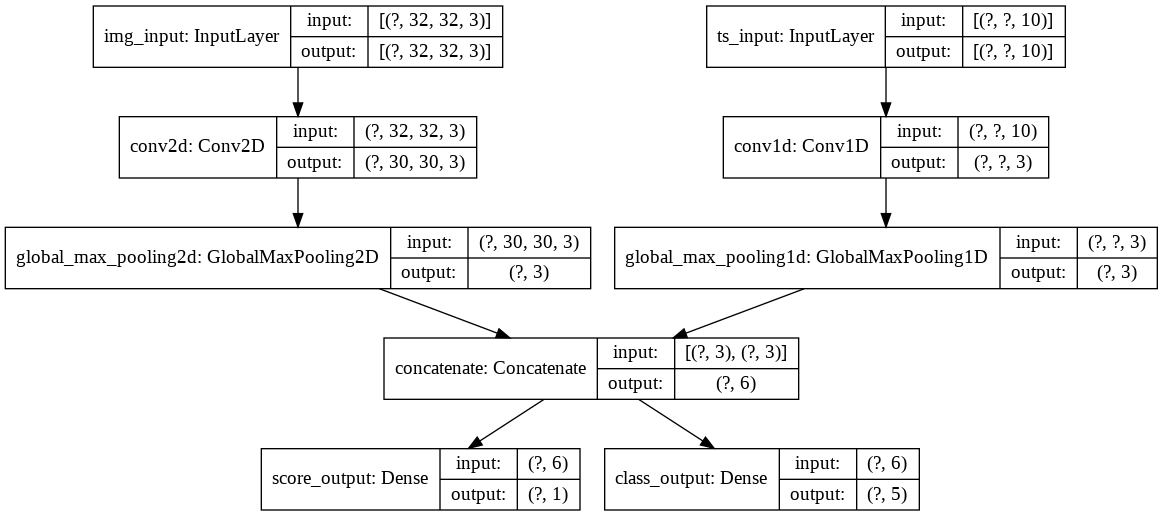

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

如果我们仅将单个损失函数传递给模型，则每个输出将应用相同的损失函数（在示例中不合适）。

同样，指标也可以有相关的操作：

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

由于我们对每个输出层进行了命名，因此我们还可以通过字典指定每个输出的损失和指标：

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

如果你有两个以上的输出，我们建议使用显式名称和字典。

可以使用`loss_weights`参数为不同的于输出的损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过赋予类别损失2倍的权重，来提升“得分”损失的影响）：

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

如果这些输出仅用于预测而不是训练，你还可以选择不为这些输出计算损失：

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

将数据传递给多输入或多输出模型的方式与在编译中指定损失函数的方式类似：你可以传递**NumPy数组的列表**（以1:1映射到接收损失函数的输出）或**将输出名称映射到NumPy数组**。

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# 生成模拟NumPy数据
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

4/4 [==============================] - 0s 7ms/step - loss: 4.1858 - score_output_loss: 0.1586 - class_output_loss: 4.0272


下面是使用`Dataset`的示例：与我们对NumPy数组所做的类似，`Dataset`应返回一个字典元组。

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

2/2 [==============================] - 0s 29ms/step - loss: 4.1520 - score_output_loss: 0.1274 - class_output_loss: 4.0246


### **使用回调**

Keras中的回调是在训练期间的不同时间点被调用的（在epoch开始时，在批处理结束时，在epoch结束时等），因此，回调可以实现如下的行为：

+ 在训练过程中的不同时间点进行验证（优于内置的按epoch验证）
+ 定期或在超过一定精度阈值时对模型进行检查
+ 当训练似乎停滞不前时，更改模型的学习率
+ 当训练似乎停滞不前时，对顶层进行微调
+ 在训练结束或超出某个性能阈值时发送电子邮件或即时消息通知
+ 等等

回调可以以列表的方式，传递给`fit()`进行调用：

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # 当`val_loss`不再提升时，停止训练
        monitor="val_loss",
        # 将"损失下降不超过1e-2"作为不再提升的标准
        min_delta=1e-2,
        # 将"至少执行两个epoch"作为不再提升的标准
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20
625/625 [==============================] - 3s 4ms/step - loss: 0.3707 - sparse_categorical_accuracy: 0.8951 - val_loss: 0.2663 - val_sparse_categorical_accuracy: 0.9202
Epoch 2/20
625/625 [==============================] - 2s 4ms/step - loss: 0.1714 - sparse_categorical_accuracy: 0.9497 - val_loss: 0.1776 - val_sparse_categorical_accuracy: 0.9459
Epoch 3/20
625/625 [==============================] - 2s 4ms/step - loss: 0.1262 - sparse_categorical_accuracy: 0.9614 - val_loss: 0.1619 - val_sparse_categorical_accuracy: 0.9487
Epoch 4/20
625/625 [==============================] - 2s 4ms/step - loss: 0.0989 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.1558 - val_sparse_categorical_accuracy: 0.9530
Epoch 5/20
625/625 [==============================] - 2s 4ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.1449 - val_sparse_categorical_accuracy: 0.9589
Epoch 6/20
625/625 [==============================] - 2s 4ms/step - loss: 0.0714 - sparse_categorica

#### **有许多内置的回调可以使用**
+ `ModelCheckpoint`：定期保存模型
+ `EarlyStopping`：当训练不再改善验证指标时，停止训练
+ `TensorBoard`：定期在[TensorBoard](https://www.tensorflow.org/tensorboard)中编写可视化的模型日志（更多详细信息，请参见“可视化”部分）
+ `CSVLogger`：将损失和指标数据保存到CSV文件
+ 等等

有关完整的内置回调方法列表，请参见[回调文档](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/)。

#### **自定义回调**

你可以通过继承基类[`keras.callbacks.Callback`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)来创建自定义回调。回调可以通过类属性`self.model`访问其关联的模型。

确保已经阅读了完整的[编写自定义回调的指南](https://www.tensorflow.org/guide/keras/custom_callback/)。

下面是一个简单的示例，在训练过程中保存了每个批量的损失值列表：

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

#### **模型的检查点**

在相对较大的数据集上训练模型时，至关重要的是要定期保存模型的检查点。

最简单的方法是使用`ModelCheckpoint`回调：

In [38]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # 保存模型的路径
        # 下面的两个参数表示为，当且仅当`val_loss`分数提高时，才会覆盖当前检查点。
        # 保存的模型名称将包含当前epoch。
        filepath="mymodel_{epoch}",
        save_best_only=True,  # 仅在`val_loss`得到提升的情况下保存模型。
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2
614/625 [============================>.] - ETA: 0s - loss: 0.3874 - sparse_categorical_accuracy: 0.8929
Epoch 00001: val_loss improved from inf to 0.26507, saving model to mymodel_1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mymodel_1/assets
625/625 [==============================] - 3s 5ms/step - loss: 0.3839 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9214
Epoch 2/2
615/625 [============================>.] - ETA: 0s - loss: 0.1814 - sparse_categorical_accuracy: 0.9470
Epoch 00002: val_loss improved from 0.26507 to 0.18677, saving model to mymodel_2
INFO:tensorflow:Assets written to: mymodel_2/assets
625/625 [==============================] - 3s 5ms/step - loss: 0.1813 - sparse_categorical_accuracy: 0.9470 - val_loss: 0.1868 - val_sparse_categorical_accuracy: 0.9427


`ModelCheckpoint`回调可用于实现容错：在随机中断训练的情况下，能够从模型的最后保存状态重新开始训练。下面是一个基本示例：

In [39]:
import os

# 准备一个目录来存储所有的检查点。
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # 如果没有检查点可用，将还原最新模型，或创建新模型
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # 回调中每100个批量保存一次SavedModel。
    # 我们将训练损失包含在保存的模型名称中。
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model
1563/1563 [==============================] - 14s 9ms/step - loss: 0.3022 - sparse_categorical_accuracy: 0.9126


你也可以调用自己的回调函数来保存和恢复模型。

有关序列化和保存的完整指南，请参见[模型的保存和序列化指南](https://www.tensorflow.org/guide/keras/save_and_serialize/)。

### **使用学习率策略**

训练深度学习模型的常见模式是随着训练的进行逐渐减少学习率。这通常称为“学习率衰减”。

学习率衰减策略可以是静态的（根据当前epoch或当前批量索引预先确定），也可以是动态的（响应于模型的当前行为，尤其是验证损失）。

#### **将时间表传递给优化器**
通过将策略对象作为优化器中的`learning_rate`参数进行传递，你可以轻松使用静态学习率衰减策略：

In [ ]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

有几个内置的策略：`ExponentialDecay`，`PiecewiseConstantDeca`y，`PolynomialDecay`和`InverseTimeDecay`。

#### **使用回调实现动态学习率策略**
由于优化器无法访问验证指标，因此无法使用这些策略对象实现动态学习率策略（例如，当验证损失不再改善时降低学习率）。

然而，回调可以访问所有指标，包括验证指标！因此，你可以通过使用回调来修改优化器上的当前学习率，从而实现此模式。实际上，它已经实现为内置回调，即`ReduceLROnPlateau`。

### **可视化训练期间的损失和指标**
在训练期间密切监控模型的最佳方法是使用**TensorBoard**，这是一个基于浏览器的应用程序，你可以在本地运行该程序，它为你提供如下功能：
+ 损失以及用于训练和评估的指标的图表
+ （可选）可视化图层激活的直方图
+ （可选）你的`Embedding`层学习到的嵌入空间的3D可视化

如果你是通过pip安装了TensorFlow，则应该能够从命令行启动TensorBoard：

In [ ]:
tensorboard --logdir=/full_path_to_your_logs

#### **使用TensorBoard回调**
使用`TensorBoard`回调最简单的方法是，将TensorBoard搭配Keras模型和fit方法一起使用。

在最简单的情况下，只需指定你希望回调时，日志的储存位置，就可以了：

In [40]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # 记录直方图可视化的频率
    embeddings_freq=0,  # 记录嵌入可视化的频率
    update_freq="epoch",
)  # 写入日志的频率（默认值：每个epoch一次）

获取更多有关信息，请参见[TensorBoard回调的文档](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/tensorboard/)。